In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.special import gamma as gamma_func
from Sk import Sk as p_kp
from scipy.io import loadmat


In [2]:
# use KAN
import yaml
import sys
sys.path.append('KAN/')
from use_KAN import *
import use_KAN
with open('./KAN/setup_model_9_7.txt', 'r') as file:
    config = yaml.safe_load(file)
device = torch.device('cpu')
model_KAN = use_KAN.build_model(config['Model Setup'], device=device)
model_KAN.load_state_dict(torch.load('./KAN/saved_model/KAN/model_9_7_sin_full_ft.pth'))
def f_SQ_KAN(model, x, Q=Q):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))
checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0


## Produce synthetic data

In [3]:
def S_hs(QD, phi):
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    G_hs = (alpha * (np.sin(QD) - QD * np.cos(QD)) / QD**2 +
            beta * (2 * QD * np.sin(QD) + (2 - QD**2) * np.cos(QD) - 2) / QD**3 +
            gama * (-QD**4 * np.cos(QD) + 4 * ((3 * QD**2 - 6) * np.cos(QD) +
            (QD**3 - 6 * QD) * np.sin(QD) + 6)) / QD**5)
    
    S = 1 / (24 * phi * G_hs/ QD + 1)
    
    return S

def S_yukawa(QD, phi, kappa, A, Q_low = 2, Q_high = 2.5):
    x = np.array([phi, kappa, A])
    Q_list = np.linspace(0, np.max(QD), 100)
    x[2] = np.log(x[2])
    x = x.reshape(1, -1)
    x = to_torch_device(x)
    q = Q_list
    S_list = f_SQ_KAN(model_KAN, x, Q=q).detach().numpy()[0]
    # Fit a quadratic function to the range Q = 2 to 2.5
    Q_fit = Q_list[(Q_list >= Q_low) & (Q_list <= Q_high)]
    S_fit = S_list[(Q_list >= Q_low) & (Q_list <= Q_high)]
    X_fit = np.vstack([Q_fit**2, np.ones(Q_fit.shape)]).T
    coefficients = np.linalg.lstsq(X_fit, S_fit, rcond=None)[0]

    # Fill Q < Q_low using the quadratic fit
    S_list[Q_list < Q_low] = coefficients[0] * Q_list[Q_list < Q_low]**2 + coefficients[1]
    f_S = interp1d(Q_list, S_list, kind='cubic')
    
    S = f_S(QD)
    
    return S

def P_hs(QD):
    P = (3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1    
    return P

def P_ss(QD, softness=0.2):
    P = np.exp(-QD**2/2*softness**2)*(3*(np.sin(QD/2)-QD/2*np.cos(QD/2))/(QD/2)**3)**2
    P[QD==0] = 1  
    return P

def P_fuzzy(QR, R2, sigma1, sigma2, rc):
    j1 = lambda QR: (np.sin(QR)-QR*np.cos(QR))/QR**2
    F1 = lambda QR, Qsigma: 3*j1(QR)*np.exp(-(Qsigma/2)**2)/QR
    
    QR1 = QR
    QR2 = QR*R2
    Qsigma2 = QR*sigma2
    Qsigma1 = QR*sigma1
    
    P = (rc*F1(QR1,Qsigma1)+(1-rc)*F1(QR2,Qsigma2))**2
    
    return P

# def P_star(QR, Rg):
#     P = ((1-np.exp(-QR**2*Rg**2))/(QR**2*Rg**2))**2
    
#     return P

# def p_debye(Q,Rg):
#     QRg = Q*Rg
#     u = QRg**2
#     p = 2*(np.exp(-u)+u-1)/(u**2)
#     p[QRg==0] = 1
#     return p

def P_star(Q, Rg, f):
    QRg = Q*Rg
    u = QRg
    v = u**2*f/(3*f-2)
    w = (1-np.exp(-v))
    P = 2/(f*v**2)*(v-w+(f-1)/2*w**2)
    P[QRg==0] = 1
    return P

def P_agg(Q, R, D, xi):
    QR = Q*R
    Qxi = Q*xi
    P = 1+D*gamma_func(D-1)/(QR**D*(1+1/Qxi**1)**((D-1)/2))*np.sin((D-1)*np.arctan(Qxi))*P_hs(QR)
    P[QR==0] = 1
    return P

def P_ts(Q, q_max, c):
    Qq = Q/q_max
    P = 1/((1-c)*((1-Qq**2)**2)+c)
    P[Qq==0] = 1
    return P

/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:798: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:808: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/ReduceOps.cpp:1760.)
  input_range = torch.std(preacts, dim=0) + 0.1
/SNS/users/ccu/miniconda3/envs/torch/lib/python3.9/site-packages/kan/MultKAN.py:809: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ../aten/src/ATen/native/Red

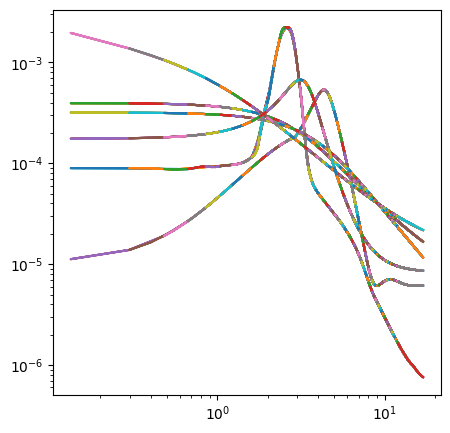

In [4]:
q_grid = np.linspace(-12, 12, 128)
n_grid = len(q_grid)**2
qx, qy = np.meshgrid(q_grid, q_grid)
q_rad = np.sqrt(qx**2 + qy**2)
I_inc = 5e-4

# colloid
scale = 1
P = P_ss(q_rad*scale, softness=0.2)
# P = P_fuzzy(q_rad*scale, 1.2, 0.02, 0.02, 1)
# P = P_star(q_rad*scale, np.sqrt(0.6)/2)
# S = S_hs(q_rad*scale, 0.25)
S = S_yukawa(q_rad*scale, 0.15, 0.2, 10, Q_low=2.75, Q_high=3)
p_colloid = P*S + I_inc*8
p_colloid[np.isfinite(p_colloid)==0] = 0
p_colloid = p_colloid/np.sum(p_colloid) 

# polymer
vfunc = np.vectorize(lambda q: p_kp(np.array([q/2,q]), 10, 0.5)[0]) 
p_polymer = vfunc(q_rad) + I_inc
p_polymer[np.isfinite(p_polymer)==0] = 0
p_polymer = p_polymer/np.sum(p_polymer) 

# sponge
data_sponge = loadmat('data/S_q_0.mat')
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/129
dq = 2*np.pi/box_size
q_sponge = np.arange(n_grid_scale/2)*dq/23
Sq_sponge = data_sponge['S_q_kxy'][1]/1e-6
Sq_sponge[0] = Sq_sponge[1]
f_interp = interp1d(q_sponge, Sq_sponge, kind='cubic')
p_sponge = f_interp(q_rad) + I_inc
p_sponge[np.isfinite(p_sponge)==0] = 0
p_sponge = p_sponge/np.sum(p_sponge) 

# star
scale = 1
f = 6
p_star = P_star(q_rad*scale, np.sqrt(0.6)/2, 3) + I_inc
p_star[np.isfinite(p_star)==0] = 0
p_star = p_star/np.sum(p_star)

# fractal aggregate
D = 1.7
R = 0.1
xi = 1
p_agg = P_agg(q_rad, R, D, xi) + I_inc
p_agg[np.isfinite(p_agg)==0] = 0
p_agg = p_agg/np.sum(p_agg)

# Teubnar Strey
q_max = np.pi
c = 0.25
p_ts = P_ts(q_rad, q_max, c)/100 + I_inc
p_ts[np.isfinite(p_ts)==0] = 0
p_ts = p_ts/np.sum(p_ts)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)

ax.plot(q_rad, p_colloid, label='Colloid')
ax.plot(q_rad, p_polymer, label='Polymer')
ax.plot(q_rad, p_sponge, label='Sponge')
ax.plot(q_rad, p_star, label='Star')
ax.plot(q_rad, p_agg, label='Fractal Aggregate')
ax.plot(q_rad, p_ts, label='Teubnar Strey')


ax.set_yscale('log')
ax.set_xscale('log')

In [5]:
n_sample = 10000

#### generate random samples
n_pixel = n_sample/p_colloid.shape[0]  # number of samples per pixel

# Flatten the arrays
bin_edges = np.append(q_grid - (q_grid[1] - q_grid[0]) / 2, q_grid[-1] + (q_grid[1] - q_grid[0]) / 2)
d_bins = bin_edges[1] - bin_edges[0]
q = q_grid[q_grid > 0]

def f_I_q(n_sample, p_qxy, seed =19810):
    np.random.seed(seed)
    n_pixel = n_sample/p_qxy.shape[0]  # number of samples per pixel

    # Flatten the arrays
    qx_flat = qx.flatten()
    qy_flat = qy.flatten()
    p_qxy_flat = p_qxy.flatten()

    # Normalize the probability density
    p_qxy_flat /= p_qxy_flat.sum()

    # Randomly choose indices based on the probability density
    indices = np.random.choice(len(qx_flat), size=n_sample, p=p_qxy_flat)

    # Get the sampled qx and qy values
    qx_samples = qx_flat[indices]
    qy_samples = qy_flat[indices]

    # evaluate the sampled point density in each grid

    I_q_grid, xedges, yedges = np.histogram2d(qx_samples, qy_samples, bins=[bin_edges, bin_edges])

    return I_q_grid

def f_I_q_rad(I_q_grid, q):
    # evaluate the radial averaged density
    q = q_grid[q_grid > 0]
    I_q = np.zeros_like(q)
    sum_q = np.zeros_like(q)
    n_pixels_q = np.zeros_like(q)
    I_pixels_q = []
    for i in range(len(q)):
        mask = (q_rad >= q[i] - (q[1] - q[0]) / 2) & (q_rad < q[i] + (q[1] - q[0]) / 2)
        I_pixels = I_q_grid[mask]
        sum_q[i] = I_pixels.sum()
        n_pixels_q[i] = mask.sum()
        I_q[i] = I_pixels.mean()
        
        I_pixels_q.append(I_pixels)
        
        
    return I_q, sum_q, n_pixels_q, I_pixels_q

## random sampling
I_q_grid_colloid = f_I_q(n_sample, p_colloid) ## count per pixel
I_q_colloid, sum_q_colloid, n_pixels_q_colloid, I_pixels_q_colloid = f_I_q_rad(I_q_grid_colloid, q)
I_q_th_colloid, _, _, _ = f_I_q_rad(p_colloid, q)
I_q_th_colloid = I_q_th_colloid*n_sample

I_q_grid_polymer = f_I_q(n_sample, p_polymer) ## count per pixel
I_q_polymer, sum_q_polymer, n_pixels_q_polymer, I_pixels_q_polymer = f_I_q_rad(I_q_grid_polymer, q)
I_q_th_polymer, _, _, _ = f_I_q_rad(p_polymer, q)
I_q_th_polymer = I_q_th_polymer*n_sample

I_q_grid_sponge = f_I_q(n_sample, p_sponge) ## count per pixel
I_q_sponge, sum_q_sponge, n_pixels_q_sponge, I_pixels_q_sponge = f_I_q_rad(I_q_grid_sponge, q)
I_q_th_sponge, _, _, _ = f_I_q_rad(p_sponge, q)
I_q_th_sponge = I_q_th_sponge*n_sample

I_q_grid_star = f_I_q(n_sample, p_star) ## count per pixel
I_q_star, sum_q_star, n_pixels_q_star, I_pixels_q_star = f_I_q_rad(I_q_grid_star, q)
I_q_th_star, _, _, _ = f_I_q_rad(p_star, q)
I_q_th_star = I_q_th_star*n_sample

I_q_grid_agg = f_I_q(n_sample, p_agg) ## count per pixel
I_q_agg, sum_q_agg, n_pixels_q_agg, I_pixels_q_agg = f_I_q_rad(I_q_grid_agg, q)
I_q_th_agg, _, _, _ = f_I_q_rad(p_agg, q)
I_q_th_agg = I_q_th_agg*n_sample

I_q_grid_ts = f_I_q(n_sample, p_ts) ## count per pixel
I_q_ts, sum_q_ts, n_pixels_q_ts, I_pixels_q_ts = f_I_q_rad(I_q_grid_ts, q)
I_q_th_ts, _, _, _ = f_I_q_rad(p_ts, q)
I_q_th_ts = I_q_th_ts*n_sample

/tmp/ipykernel_2866211/2425915458.py:79: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_colloid), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2866211/2425915458.py:92: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_polymer), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2866211/2425915458.py:105: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_sponge), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2866211/2425915458.py:118: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_star), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2866211/2425915458.py:131: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_agg), cmap='viridis', vmax=3, vmin=-2)
/tmp/ipykernel_2866211/2425915458.py:144: RuntimeWarning: divide by zero encountered in log
  ax.pcolormesh(qx, qy, np.log(I_q_grid_ts)

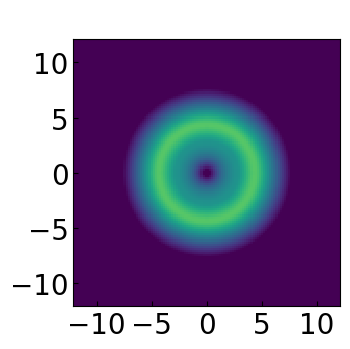

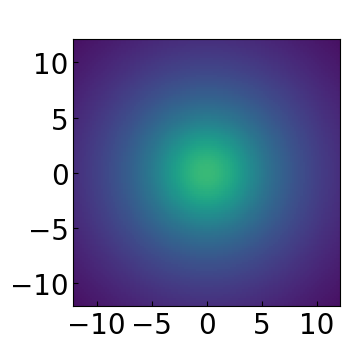

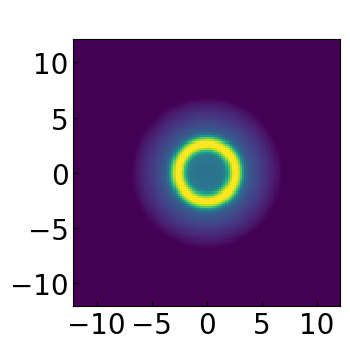

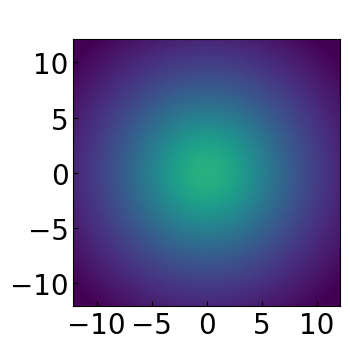

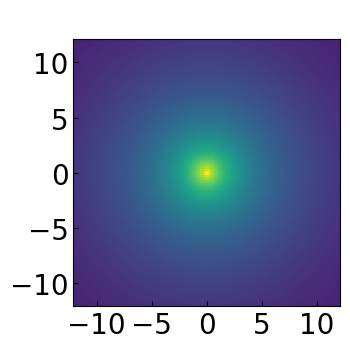

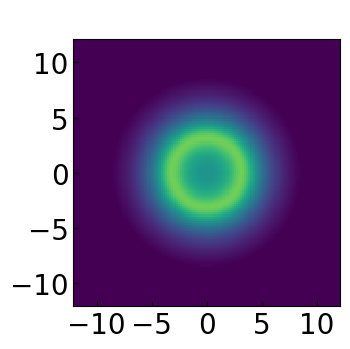

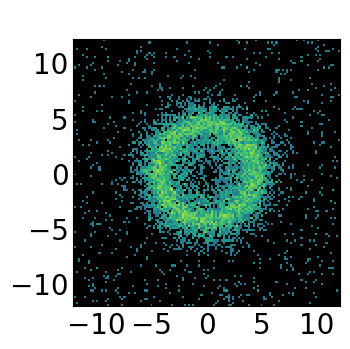

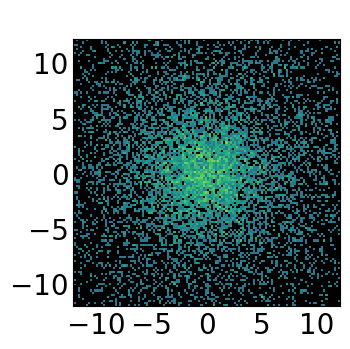

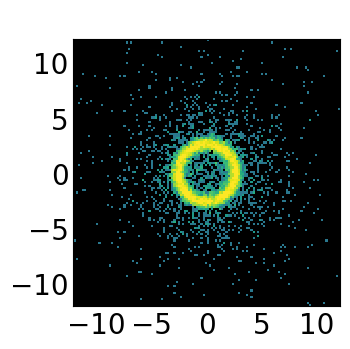

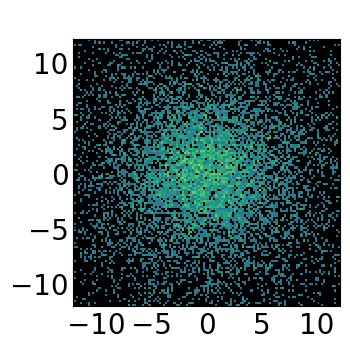

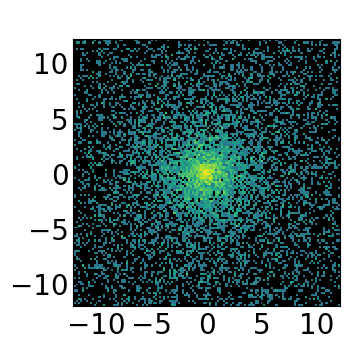

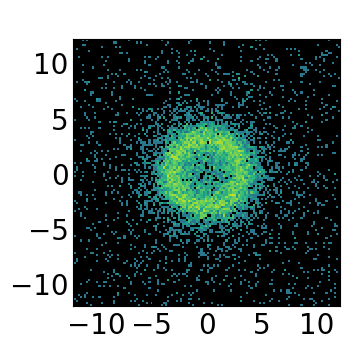

In [6]:
# ideal spectra ------------------------------------
fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_colloid*n_sample), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_polymer*n_sample), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_sponge*n_sample), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()


fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_star*n_sample), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_agg*n_sample), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(p_ts*n_sample), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
plt.tight_layout()

# sampled spectra ------------------------------------
fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_colloid), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_polymer), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_sponge), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_star), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_agg), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()

fig = plt.figure(figsize=(3.6, 3.6))
ax = plt.subplot(1, 1, 1)

ax.pcolormesh(qx, qy, np.log(I_q_grid_ts), cmap='viridis', vmax=3, vmin=-2)
# ax.set_xlabel(r'$Q_x$', fontsize=20)
# ax.set_ylabel(r'$Q_y$', fontsize=20)
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([-10, -5, 0, 5, 10])
ax.tick_params(direction='in', labelsize=20)
ax.set_title(' ', fontsize=20)
ax.set_facecolor('black')
plt.tight_layout()




## GPR

In [7]:
def f_loglin(x, x_c=1):
    return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))
def f_loglin_inv(y, y_c=0):
    return np.where(y < y_c, (1+y-y_c)*np.exp(y_c), np.exp(y))
def f_loglin_deriv(x, x_c=1):
    return np.where(x < x_c, 1/x_c, 1/x)

In [8]:
def desmear(Q,IQ,IQ_er,sigma_Q,n=3,sigmascale=1):
    I_ex = IQ
    I_ex_pos = I_ex[2*n:]
    I_ex_neg = I_ex[:-2*n]
    I_ex = I_ex[n:-n]
    sigma_Q_c = sigma_Q[n:-n]/sigmascale
    # sigma_Q_c = Q[n:-n]

    DQ = Q[n:] - Q[:-n]
    DQ_pos = DQ[n:]
    DQ_neg = DQ[:-n]

    I_ex2 = 2*(DQ_neg*I_ex_pos + DQ_pos*I_ex_neg - I_ex*(DQ_pos+DQ_neg))/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    I_des = I_ex - sigma_Q_c**2/2*I_ex2
    Q_des = Q[n:-n]

    # DI_ex = IQ_er
    # DI_ex[DI_ex==0] = np.min(DI_ex[DI_ex>0])
    # DI_ex_pos = DI_ex[2*n:]
    # DI_ex_neg = DI_ex[:-2*n]
    # DI_ex = DI_ex[n:-n]

    # DI_ex2_Sq = 4*((DQ_neg*DI_ex_pos)**2 + (DQ_pos*DI_ex_neg)**2 + ((DQ_neg+DQ_pos)*DI_ex)**2)/(DQ_pos*DQ_neg*(DQ_pos+DQ_neg))
    # DI_des = DI_ex*(1+sigma_Q_c**4/4*DI_ex2_Sq/DI_ex**2)
    
    return I_des

def f_log_likelihood(y, y_err, x, x_err, importance=np.ones_like(q), z_list = np.linspace(0, 0, 1)):
    """
    likelihood of y in the distribution of x
    """
    ## average over the ovservation uncertainty   
    log_likelihood = 0   
    sum_weight = 0  
    for z in z_list:
        weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
        y_z = y + y_err*z
        log_likelihood_z = -0.5 * np.sum(((y_z - x)**2 / x_err**2 + np.log(2 * np.pi * x_err**2)))
        log_likelihood += log_likelihood_z*weight_z
        sum_weight += weight_z
    log_likelihood = log_likelihood/sum_weight
    return log_likelihood

### Colloid

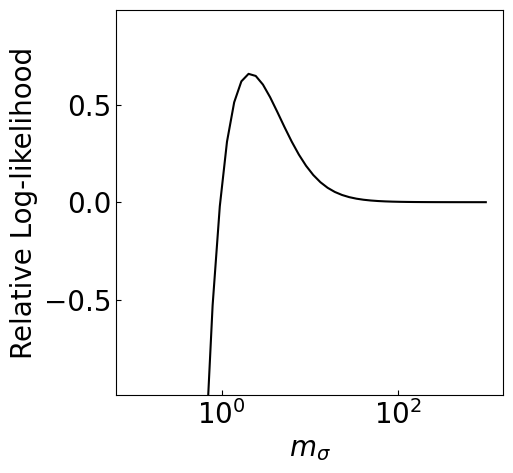

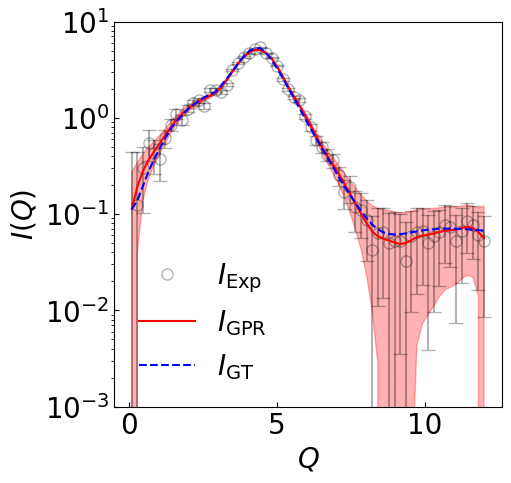

In [9]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.5

I_bg = 1e-1

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_colloid) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_colloid, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(((q[i])-(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    ## define kernel function
    y_data = I_q_concat
    y_bg = I_q_mean_gf
    y_bg_concat = I_q_mean_gf_concat
    y_gt = I_q_th
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    # def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
    #     ## average over the ovservation uncertainty   
    #     log_likelihood = 0   
    #     sum_weight = 0  
    #     for z in np.linspace(0, 0, 1):
    #         weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
    #         y_z = y + y_err*z
    #         log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
    #         log_likelihood += log_likelihood_z*weight_z
    #         sum_weight += weight_z
    #     log_likelihood = log_likelihood/sum_weight
    #     return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, mu_s + y_bg, '-r', label=r'$I_\mathrm{GPR}$')
ax.fill_between(q_s, mu_s - std_s + y_bg, mu_s + std_s + y_bg, color='r', alpha=0.3)

ax.plot(q, y_gt , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=20)

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y + y_bg, 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
# ax.errorbar(q_x, y + y_bg, yerr=y_err, fmt='none', ecolor='k', capsize=5, alpha=0.3)

# ax.plot(q_s, mu_s/std_s, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)

#### effect on data quality

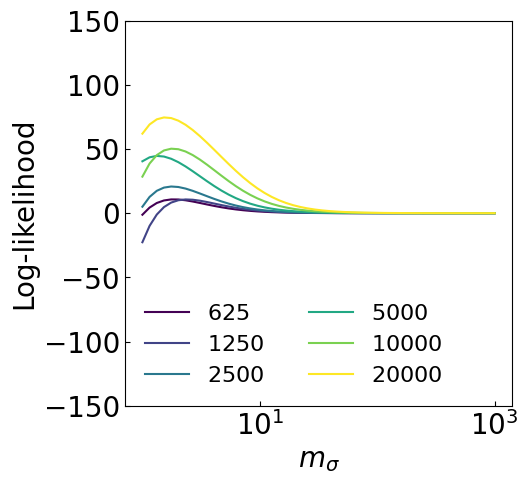

In [10]:
filter_size = 0.4

n_trial = 1
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

n_sample_list = [625, 1250, 2500, 5000, 10000, 20000]
# n_sample_list = np.linspace(1000, 20000, 10)
for i_n, n_sample in enumerate(n_sample_list):
    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]
    sv_size = 15
    gf_size = 2


    q_list = []
    I_q_gf_list = []
    I_q_sv_list = []
    I_q_list = []
    sum_q_list = []
    n_pixels_q_list = []
    I_err_list = []

    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_colloid, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_colloid, q)
        I_q_th = I_q_th*n_sample
        I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
        I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
        
        I_data_gf = np.zeros_like(q)
        for i in range(len(q)):
            weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
            weight_list = weight_list/np.sum(weight_list)
            I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
        
        I_q_gf_list.append(I_q_gf)
        I_q_sv_list.append(I_q_sv)
        
        I_q_list.append(I_q)
        sum_q_list.append(sum_q)
        n_pixels_q_list.append(n_pixels_q)
        q_list.append(q)
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
        I_err_list.append(I_err_q)
        
    q_concat = np.concatenate(q_list)
    sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
    n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
    I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
    I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
    I_q_gf_concat = np.concatenate(I_q_gf_list)
    I_q_sv_concat = np.concatenate(I_q_sv_list)
    I_q_concat = np.concatenate(I_q_list)

    # average over trials, obtain smoothed I(q) as background
    I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
    I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
    I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
    I_q_mean_gf_concat = np.tile(I_q_mean_gf, n_trial)

    I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
    I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
        
    # # Plot the radial averaged density for concatenated values
    # fig = plt.figure(figsize=(6, 6))
    # ax = plt.subplot(1, 1, 1)
    # for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
    #     label_I_q = None
    #     label_I_q_gf = None
    #     if i == 0:
    #         label_I_q = 'I_q'
    #         label_I_q_gf = 'I_q_gf'
    #     ax.plot(q, I_q, 'ok', label=label_I_q)
    #     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
    # ax.set_xscale('log')
    # ax.set_yscale('log')
    # ax.legend(frameon=False)

    ## GPR
    sigma_list = np.logspace(0, 3, 50)
    log_likelihood_list = []
    for sigma in sigma_list:
        lmbda = filter_size
        # sigma = 10

        ## define kernel function
        y_data = I_q_concat
        y_bg = I_q_mean_gf
        y_bg_concat = I_q_mean_gf_concat
        y_gt = I_q_th
        y = y_data-y_bg

        # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
        y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))
        # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

        # scale by a factor to check whether error estimation is correct
        m_factor = 1
        y_bg = y_bg*m_factor
        y_bg_concat = y_bg_concat*m_factor
        y_gt = y_gt*m_factor
        y = y*m_factor
        y_err = y_err*m_factor
        y_data = y_data*m_factor
        sig_var = np.mean(y**2)

        q_x = q_concat
        q_s = q

        def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
            if std_1 is None:
                std_1 = np.ones_like(q1)
            if std_2 is None:
                std_2 = np.ones_like(q2)
            K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
            return K

        # f_q = lambda q: np.log(q)
        f_q = lambda q: q
        f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
        k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
        std_s = np.sqrt(var_s)

        log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
        log_likelihood_list.append(log_likelihood)
        
    log_likelihood_list = np.array(log_likelihood_list)
    log_likelihood_list = log_likelihood_list - log_likelihood_list[-1]

    ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample}$')
    ax.set_xscale('log')
    # ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
    ax.set_ylim([-150, 150])
    ax.tick_params(direction='in', labelsize=20)
    ax.set_xlabel(r'$m_\sigma$', fontsize=20)
    ax.set_ylabel(r'Log-likelihood', fontsize=20)

    sigma_best = sigma_list[np.argmax(log_likelihood_list)]
    
ax.legend(frameon=False, fontsize=16, ncol=2)

# # # GPR with best sigma
# # f_q = lambda q: np.log(q)
# f_q = lambda q: q
# f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
# K_sigma = np.diag(f_y_err(y_err))
# # K_sigma = sigma**2*np.eye(len(q_x))
# K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
# K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
# k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

# L = np.linalg.cholesky(K_xx)
# alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
# v = np.linalg.solve(L, K_xs)
# mu_s = K_xs.T @ alpha
# cov_s = k_ss - v.T @ v
# var_s = np.diag(cov_s)*y_err**2
# std_s = np.sqrt(var_s)



#### Estimate relative entropy

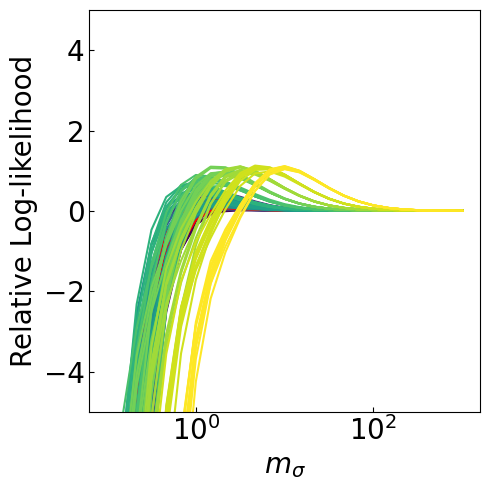

In [11]:
n_trial = 10
filter_size = 0.4
I_bg = I_inc
use_log_I = False
use_log_Q = False

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        seed_trial = np.random.randint(1e6)
        I_q_grid = f_I_q(n_sample, p_colloid) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_colloid, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(2):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 2
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.36
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_2866211/52380065.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'or', color='k')
/tmp/ipykernel_2866211/52380065.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -0.5046308144423359


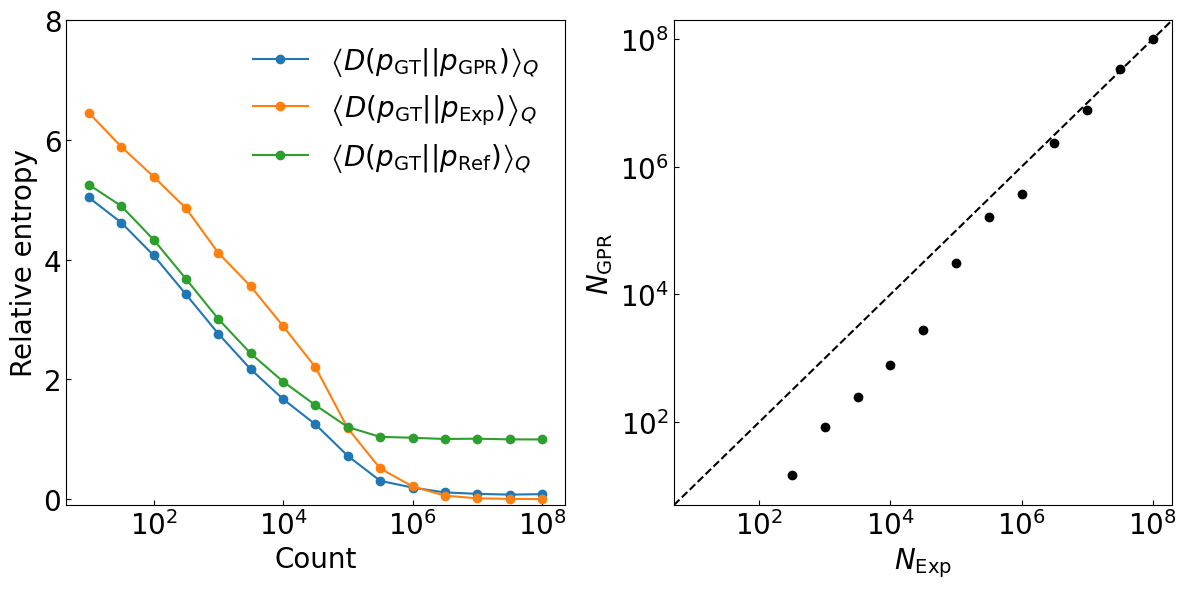

In [12]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x = np.log(n_sample_list[mask])
y = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x, y, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 8])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

ax = axs[1]
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

ax.plot(n_sample_list, time_gpr, 'or', color='k')
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1/2, 1e8*2])
ax.set_ylim([1e1/2, 1e8*2])
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()

filename = 'dKL_synth_colloid.dat'
np.savetxt(filename, np.c_[n_sample_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')


### Polymer

5.428675439323859


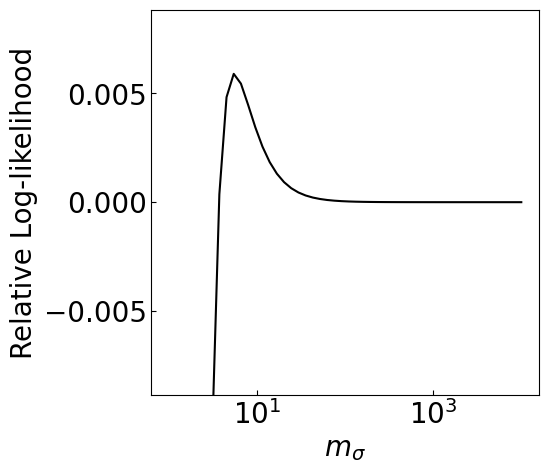

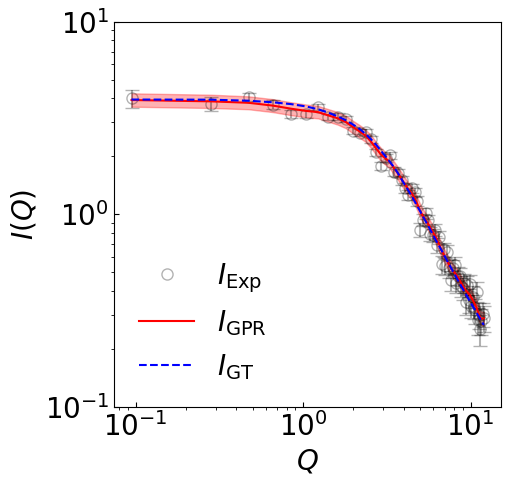

In [13]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.2

I_bg = 0

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_polymer) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_polymer, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(0, 4, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size/2
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg
    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q_concat)
    y_bg = f_I(I_q_mean_gf)
    y_bg_concat = f_I(I_q_mean_gf_concat)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label=r'$I_\mathrm{GPR}$')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-1, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=20)

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

#### Estimate relative entropy

/tmp/ipykernel_2866211/3846275584.py:2: RuntimeWarning: invalid value encountered in log
  return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))


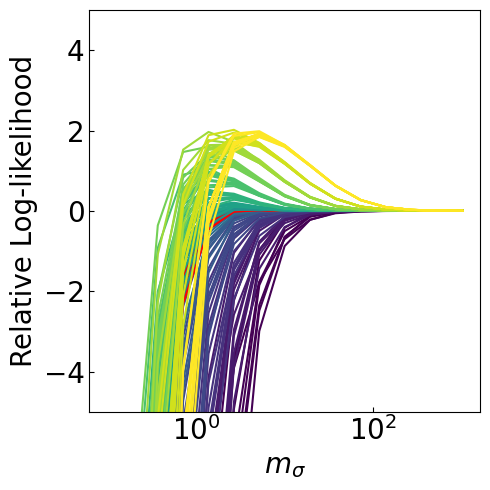

In [14]:
n_trial = 10
filter_size = 0.15
I_bg = 0.1
use_log_I = True
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_polymer, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_polymer, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(2):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 2
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 3, 15)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.1
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_2866211/3814189532.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'or', color='k')
/tmp/ipykernel_2866211/3814189532.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -2.7647737332350752


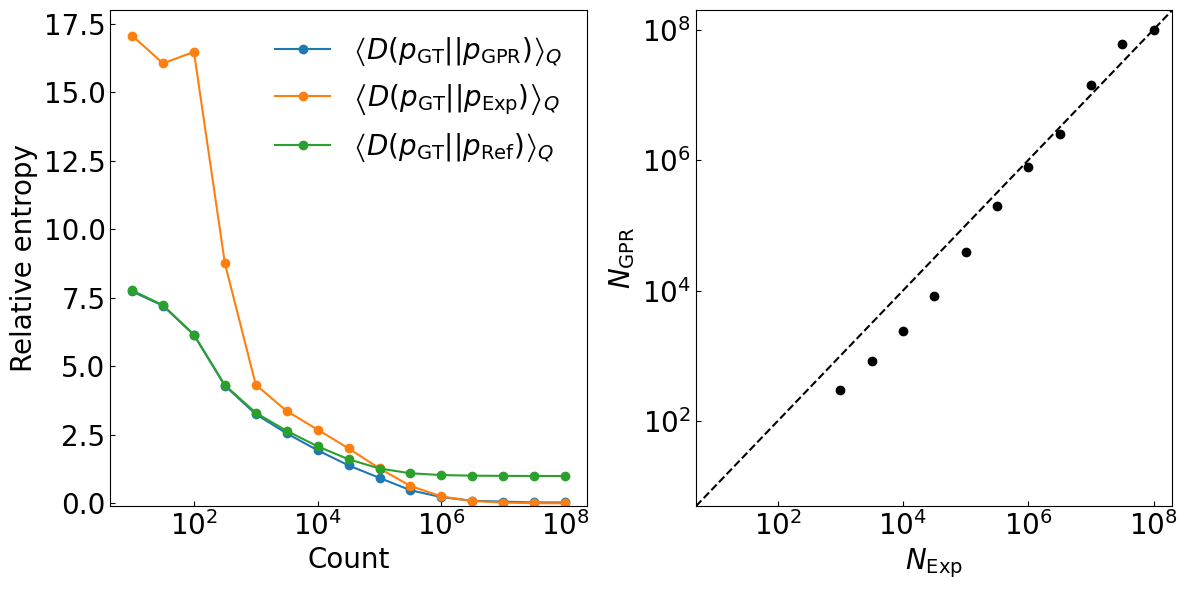

In [15]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x = np.log(n_sample_list[mask])
y = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x, y, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 18])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

ax = axs[1]
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(n_sample_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

ax.plot(n_sample_list, time_gpr, 'or', color='k')
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1/2, 1e8*2])
ax.set_ylim([1e1/2, 1e8*2])
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()

filename = 'dKL_synth_polymer.dat'
np.savetxt(filename, np.c_[n_sample_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')


### Sponge

1.1513953993264467


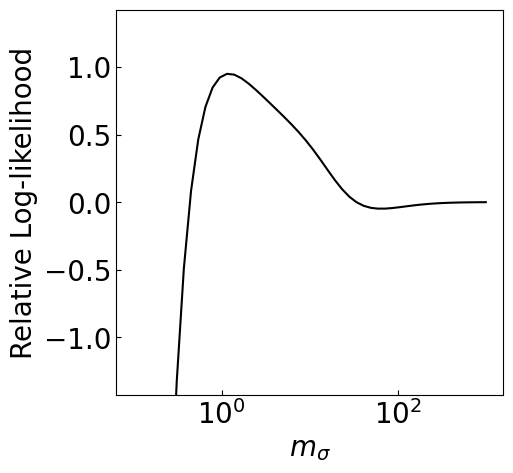

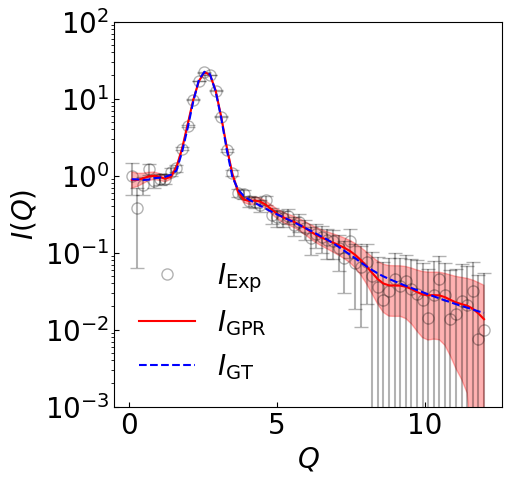

In [16]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.8

I_bg = 0.05

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

f_I = lambda I: f_loglin(I, x_c=I_bg*2)
f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_sponge) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_sponge, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-(q[i]-q)/filter_size**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = f_inv_I(np.sum(f_I(I_q)*weight_list))
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    lmbda = 0.5
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg

    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q_concat)
    y_bg = f_I(I_q_mean_gf)
    y_bg_concat = f_I(I_q_mean_gf_concat)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg 

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    # f_q = lambda q: np.log(q)
    f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    # def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
    #     ## average over the ovservation uncertainty   
    #     log_likelihood = 0   
    #     sum_weight = 0  
    #     for z in np.linspace(0, 0, 1):
    #         weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
    #         y_z = y + y_err*z
    #         log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
    #         log_likelihood += log_likelihood_z*weight_z
    #         sum_weight += weight_z
    #     log_likelihood = log_likelihood/sum_weight
    #     return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label=r'$I_\mathrm{GPR}$')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, f_inv_I(y_bg_concat), '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-3, 1e2])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=20, loc='lower left')

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# # ax.set_yscale('log')

#### Estimate relative entropy

/tmp/ipykernel_2866211/3846275584.py:2: RuntimeWarning: invalid value encountered in log
  return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))


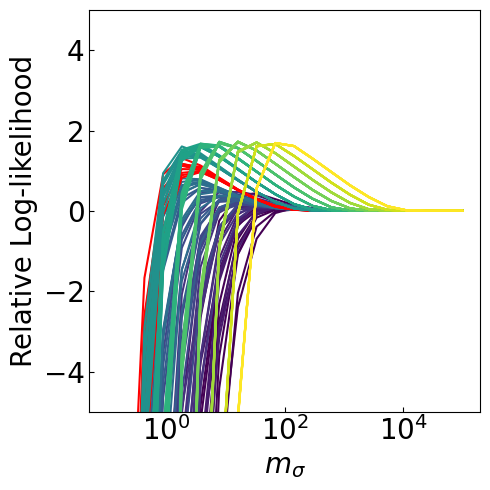

In [17]:
n_trial = 10
filter_size = 0.8
I_bg = 0.05
use_log_I = True
use_log_Q = False

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_sponge, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_sponge, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            # n_sm = 2
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 5, 20)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = filter_size
            lmbda = 0.5
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_2866211/4160963104.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'or', color='k')
/tmp/ipykernel_2866211/4160963104.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -0.8815845516355272


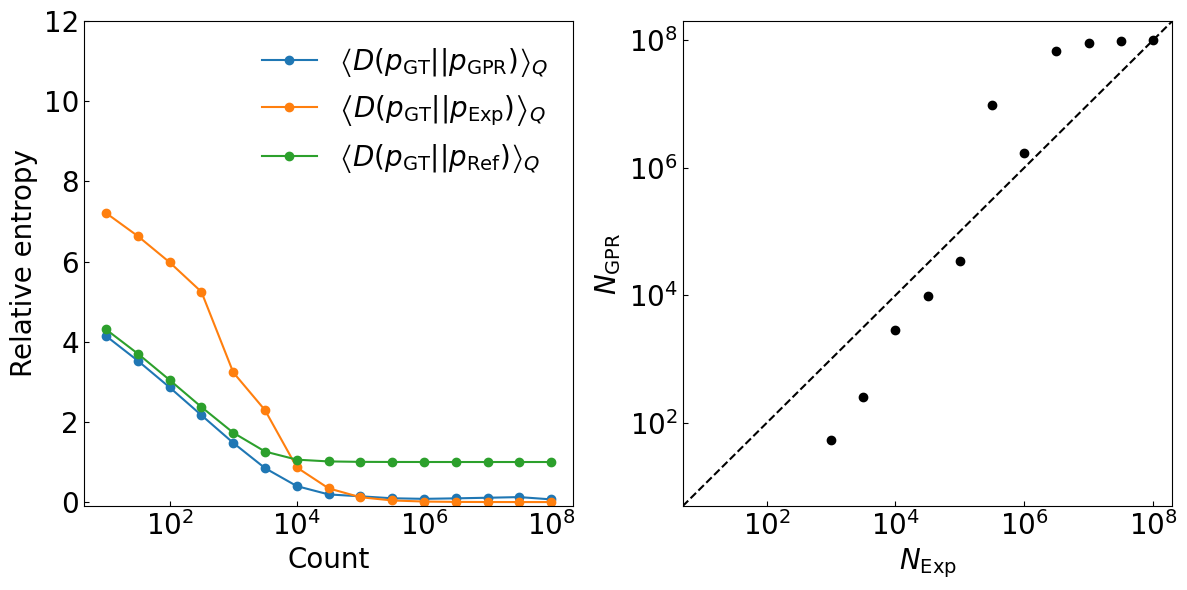

In [18]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x = np.log(n_sample_list[mask])
y = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x, y, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 12])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

ax = axs[1]
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

ax.plot(n_sample_list, time_gpr, 'or', color='k')
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1/2, 1e8*2])
ax.set_ylim([1e1/2, 1e8*2])
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()

filename = 'dKL_synth_sponge.dat'
np.savetxt(filename, np.c_[n_sample_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')


### Star Polymer

3.5564803062231283


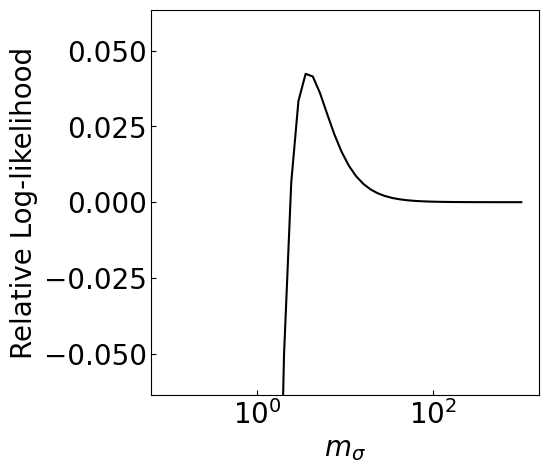

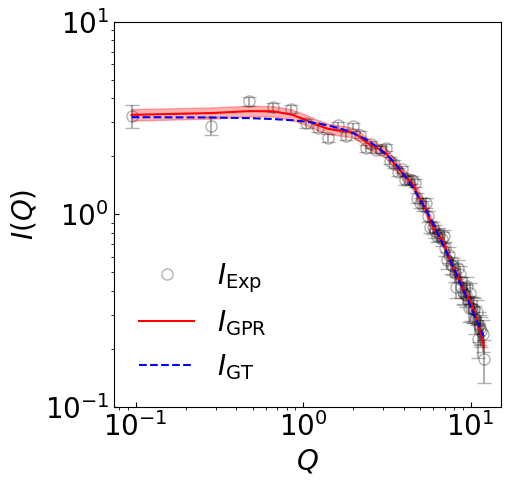

In [19]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.2

I_bg = 0

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_star, seed=2457) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_star, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg
    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q_concat)
    y_bg = f_I(I_q_mean_gf)
    y_bg_concat = f_I(I_q_mean_gf_concat)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label=r'$I_\mathrm{GPR}$')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-1, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=20)

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

#### Estimate relative entropy

/tmp/ipykernel_2866211/3846275584.py:2: RuntimeWarning: invalid value encountered in log
  return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))


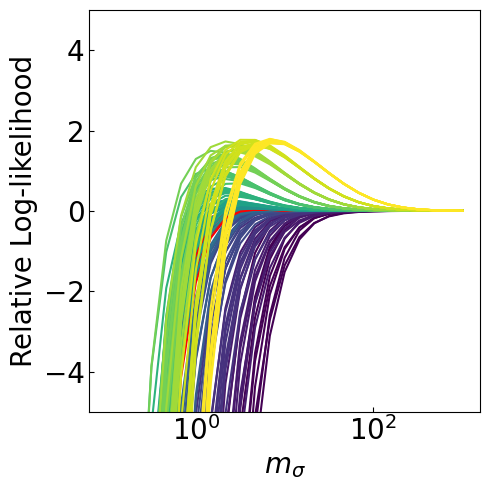

In [20]:
n_trial = 10
filter_size = 0.15
I_bg = 0.1
use_log_I = True
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_star, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_star, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(2):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 2
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.135
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_2866211/2234508396.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'or', color='k')
/tmp/ipykernel_2866211/2234508396.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -2.6564397525764307


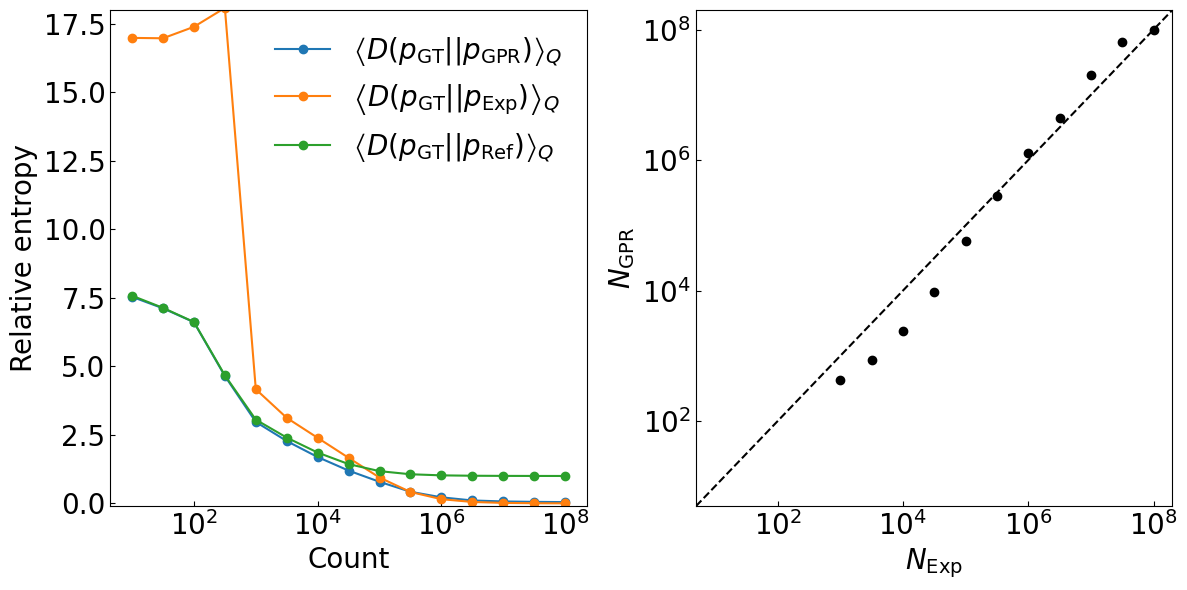

In [21]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x = np.log(n_sample_list[mask])
y = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x, y, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 18])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

ax = axs[1]
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(n_sample_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

ax.plot(n_sample_list, time_gpr, 'or', color='k')
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1/2, 1e8*2])
ax.set_ylim([1e1/2, 1e8*2])
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()

filename = 'dKL_synth_star.dat'
np.savetxt(filename, np.c_[n_sample_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')


### Fractal Aggregate

2.4420530945486507


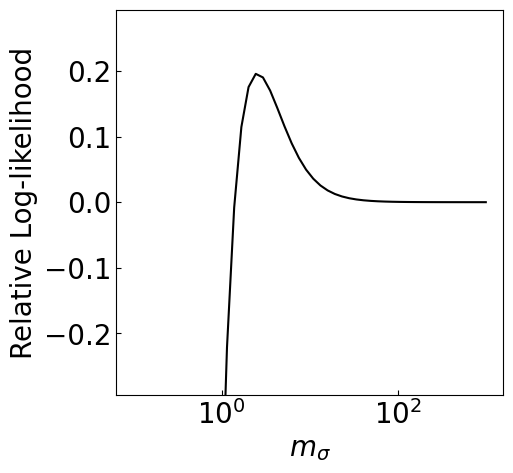

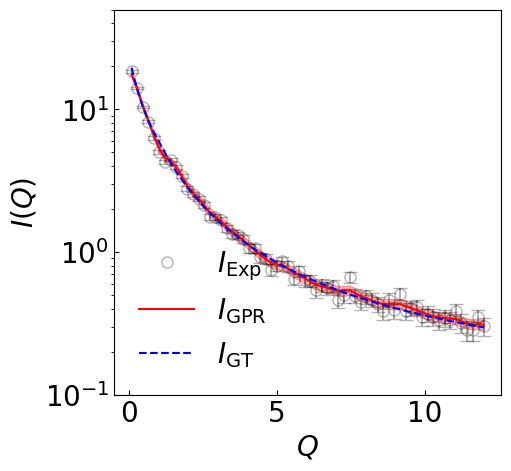

In [22]:
n_trial = 1
n_sample = 10000
dq = q_grid[1] - q_grid[0]
sv_size = 15
gf_size = 2
filter_size = 0.15

I_bg = 0

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_agg) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_agg, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_data_gf = np.zeros_like(q)
    for i in range(len(q)):
        weight_list = np.exp(-((np.log(q[i])-np.log(q))/filter_size)**2/2)
        weight_list = weight_list/np.sum(weight_list)
        I_data_gf[i] = np.exp(np.sum(np.log(I_q+I_bg)*weight_list)-I_bg)
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg
    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q_concat)
    y_bg = f_I(I_q_mean_gf)
    y_bg_concat = f_I(I_q_mean_gf_concat)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label=r'$I_\mathrm{GPR}$')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, y_bg_concat, '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-1, 5e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=20, loc='lower left')

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# ax.set_yscale('log')

#### Estimate relative entropy

/tmp/ipykernel_2866211/3846275584.py:2: RuntimeWarning: invalid value encountered in log
  return np.where(x < x_c, (x-x_c)/x_c+np.log(x_c), np.log(x))


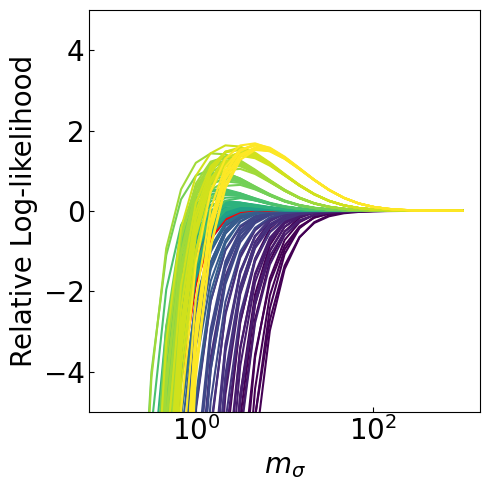

In [23]:
n_trial = 10
filter_size = 0.15
I_bg = 0.1
use_log_I = True
use_log_Q = True

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_agg, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_agg, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(2):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            n_sm = 2
            I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 3, 25)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = 0.135
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_2866211/2299782848.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'or', color='k')
/tmp/ipykernel_2866211/2299782848.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -1.3707651219773902


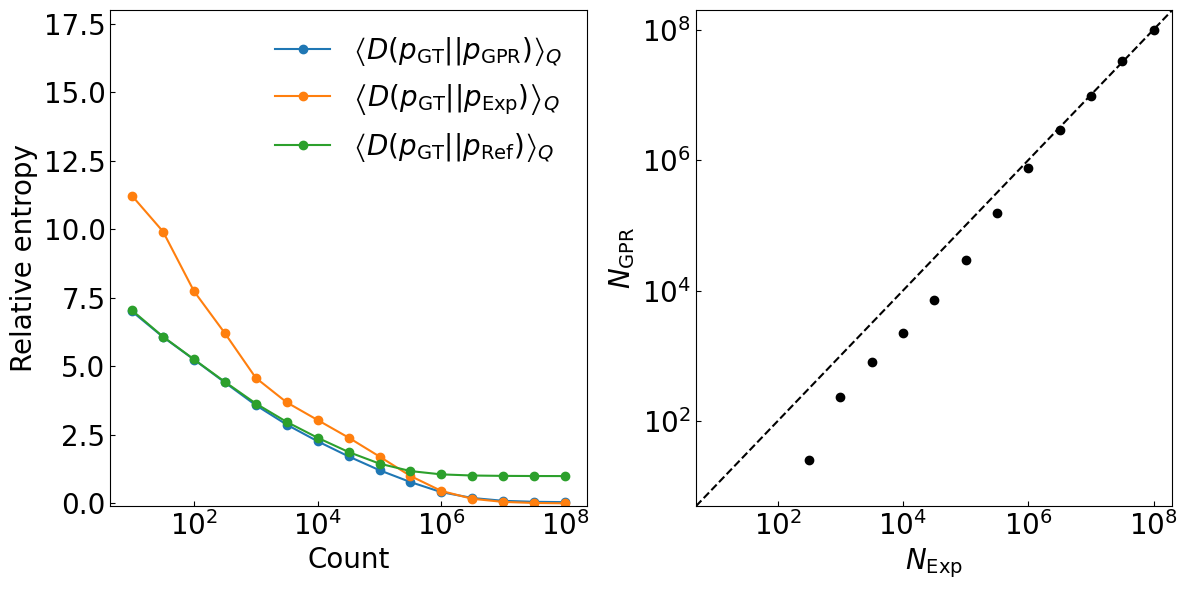

In [24]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x = np.log(n_sample_list[mask])
y = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x, y, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 18])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

ax = axs[1]
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, np.log(n_sample_list), kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = np.exp(f_interp_gpr(H_exp_gt_i))

ax.plot(n_sample_list, time_gpr, 'or', color='k')
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1/2, 1e8*2])
ax.set_ylim([1e1/2, 1e8*2])
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()

filename = 'dKL_synth_agg.dat'
np.savetxt(filename, np.c_[n_sample_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')


### Teubner Strey

2.0235896477251565


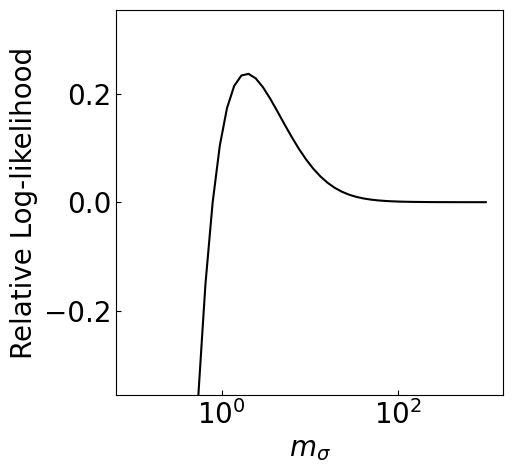

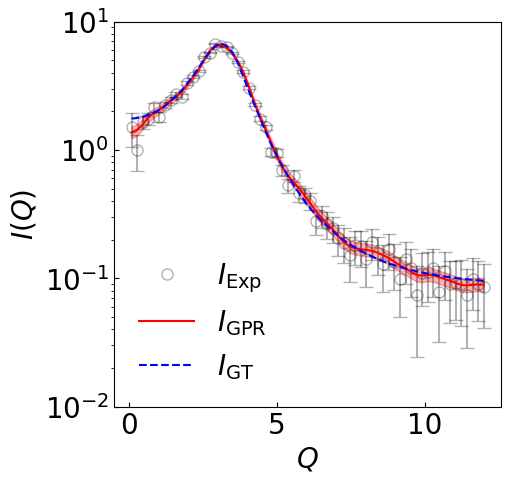

In [25]:
n_trial = 1
n_sample = 10000
filter_size = 0.27
I_bg = 0.01
use_log_I = False
use_log_Q = False

gf_size = 1
sv_size = 15

q_list = []
I_q_gf_list = []
I_q_sv_list = []
I_q_list = []
sum_q_list = []
n_pixels_q_list = []
I_err_list = []

# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

for i in range(n_trial):
    I_q_grid = f_I_q(n_sample, p_ts) ## count per pixel
    I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
    I_q_th, _, _, _ = f_I_q_rad(p_ts, q)
    I_q_th = I_q_th*n_sample
    I_q_gf = gaussian_filter1d(I_q, gf_size, mode='nearest')
    I_q_sv = savgol_filter(I_q, sv_size, 2, mode='nearest')
    
    I_q_gf = np.zeros_like(q)
    for i_iterate in range(1):
        I_q_gf_i = np.zeros_like(q)
        I_iterate = I_q - I_q_gf
        for i in range(len(q)):
            weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
            weight_list = weight_list/np.sum(weight_list)
            I_q_gf_i[i] = np.sum(I_iterate*weight_list)
        # n_sm = 2
        # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
        I_q_gf = I_q_gf + I_q_gf_i
    
    I_q_gf_list.append(I_q_gf)
    I_q_sv_list.append(I_q_sv)
    
    I_q_list.append(I_q)
    sum_q_list.append(sum_q)
    n_pixels_q_list.append(n_pixels_q)
    q_list.append(q)
    
    I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)
    I_err_list.append(I_err_q)
    
q_concat = np.concatenate(q_list)
sum_q_concat = np.concatenate(sum_q_list) # sum of total flux at each q bin
n_pixels_q_concat = np.concatenate(n_pixels_q_list) # number of detector pixel at each q bin
I_pixels_q_concat = np.concatenate(I_pixels_q) # list of neutron flux on each pixel at each q bin
I_err_concat = np.concatenate(I_err_list) # accumulated error of neutron flux at each q bin
I_q_gf_concat = np.concatenate(I_q_gf_list)
I_q_sv_concat = np.concatenate(I_q_sv_list)
I_q_concat = np.concatenate(I_q_list)

# average over trials, obtain smoothed I(q) as background
I_q_gf_mean = np.mean(I_q_gf_list, axis=0) # average over smoothed I(q)
I_q_mean_gf = gaussian_filter1d(np.mean(I_q_list, axis=0), gf_size, mode='nearest') # smooth the average I(q)
I_q_gf_mean_concat = np.tile(I_q_gf_mean, n_trial)
I_q_mean_gf_concat = np.tile(I_q_gf_mean, n_trial)

I_q_mean_sv = savgol_filter(np.mean(I_q_list, axis=0), sv_size, 2, mode='nearest') # smooth the average I(q)
I_q_mean_sv_concat = np.tile(I_q_mean_sv, n_trial)
    
# # Plot the radial averaged density for concatenated values
# fig = plt.figure(figsize=(6, 6))
# ax = plt.subplot(1, 1, 1)
# for i, (q, I_q, I_q_gf) in enumerate(zip(q_list, I_q_list, I_q_gf_list)):
#     label_I_q = None
#     label_I_q_gf = None
#     if i == 0:
#         label_I_q = 'I_q'
#         label_I_q_gf = 'I_q_gf'
#     ax.plot(q, I_q, 'ok', label=label_I_q)
#     ax.plot(q, I_q_gf, '-r', label=label_I_q_gf)
# ax.set_xscale('log')
# ax.set_yscale('log')
# ax.legend(frameon=False)

## GPR
sigma_list = np.logspace(-1, 3, 50)
log_likelihood_list = []
for sigma in sigma_list:
    lmbda = filter_size
    # lmbda = 0.27
    # sigma = 10

    f_I = lambda x: np.log(x+I_bg)
    f_inv_I = lambda x: np.exp(x)-I_bg

    
    # f_I = lambda x: x
    # f_inv_I = lambda x: x

    ## define kernel function
    y_data = f_I(I_q)
    y_bg = f_I(I_q_gf)
    y_bg_concat = f_I(I_q_gf)
    y_gt = f_I(I_q_th)
    y = y_data-y_bg 

    # y_err = np.sqrt(1/np.maximum(sum_q_concat,np.ones_like(q)))
    y_err = np.sqrt(n_sample/np.sum(n_pixels_q_concat)/np.maximum(n_pixels_q_concat,np.ones_like(q)))/I_q_concat
    # y_err = I_err_concat#/np.sqrt(np.maximum(n_pixels_q_concat,np.ones_like(q)))
    if use_log_I:
        y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

    # scale by a factor to check whether error estimation is correct
    m_factor = 1
    y_bg = y_bg*m_factor
    y_bg_concat = y_bg_concat*m_factor
    y_gt = y_gt*m_factor
    y = y*m_factor
    y_err = y_err*m_factor
    y_data = y_data*m_factor
    sig_var = np.mean(y**2)

    q_x = q_concat
    q_s = q

    def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
        if std_1 is None:
            std_1 = np.ones_like(q1)
        if std_2 is None:
            std_2 = np.ones_like(q2)
        K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
        return K

    # f_q = lambda q: np.log(q)
    # f_q = lambda q: q
    f_q = f_Q
    f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
    K_sigma = np.diag(f_y_err(y_err))
    # K_sigma = sigma**2*np.eye(len(q_x))
    K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
    K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
    k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

    L = np.linalg.cholesky(K_xx)
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    v = np.linalg.solve(L, K_xs)
    mu_s = K_xs.T @ alpha
    cov_s = k_ss - v.T @ v
    var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
    std_s = np.sqrt(var_s)

    # evaluate the log likelihood
    # def f_log_likelihood(y, y_err, mu_s, std_s, importance=np.ones_like(y)):
    #     ## average over the ovservation uncertainty   
    #     log_likelihood = 0   
    #     sum_weight = 0  
    #     for z in np.linspace(0, 0, 1):
    #         weight_z = np.exp(-z**2/2)/np.sqrt(2*np.pi)
    #         y_z = y + y_err*z
    #         log_likelihood_z = -0.5 * np.sum(((y_z - mu_s)**2 / std_s**2 + np.log(2 * np.pi * std_s**2)))
    #         log_likelihood += log_likelihood_z*weight_z
    #         sum_weight += weight_z
    #     log_likelihood = log_likelihood/sum_weight
    #     return log_likelihood

    log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
    log_likelihood_list.append(log_likelihood)
    
log_likelihood_list = np.array(log_likelihood_list)
log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q)
    
# plot the log likelihood as a function of sigma
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(sigma_list, log_likelihood_list, '-k')
ax.set_xscale('log')
ax.set_ylim([log_likelihood_list[-1]-(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5,log_likelihood_list[-1]+(np.max(log_likelihood_list)-log_likelihood_list[-1])*1.5])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'$m_\sigma$', fontsize=20)
ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

sigma_best = sigma_list[np.argmax(log_likelihood_list)]
print(sigma_best)

# # GPR with best sigma
# f_q = lambda q: np.log(q)
f_q = lambda q: q
f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
K_sigma = np.diag(f_y_err(y_err))
# K_sigma = sigma**2*np.eye(len(q_x))
K_xx = f_K_rbf(f_q(q_x), f_q(q_x), lmbda) + K_sigma
K_xs = f_K_rbf(f_q(q_x), f_q(q_s), lmbda)
k_ss = f_K_rbf(f_q(q_s), f_q(q_s), lmbda)

L = np.linalg.cholesky(K_xx)
alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
v = np.linalg.solve(L, K_xs)
mu_s = K_xs.T @ alpha
cov_s = k_ss - v.T @ v
var_s = np.diag(cov_s)*np.sqrt(sig_var)**2
# var_s = np.diag(cov_s)*y_err**2
std_s = np.sqrt(var_s)

# plot the GPR result
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot(1, 1, 1)

ax.plot(q_x, f_inv_I(y + y_bg), 'ok', markersize=8, fillstyle='none', label=r'$I_\mathrm{Exp}$', alpha=0.3) 
ax.errorbar(q_x, f_inv_I(y + y_bg), yerr=y_err*I_q_concat, fmt='none', ecolor='k', capsize=5, alpha=0.3)
ax.plot(q_s, f_inv_I(mu_s + y_bg), '-r', label=r'$I_\mathrm{GPR}$')
ax.fill_between(q_s, f_inv_I(mu_s - std_s + y_bg), f_inv_I(mu_s + std_s + y_bg), color='r', alpha=0.3)

ax.plot(q, f_inv_I(y_gt) , '--b', label=r'$I_\mathrm{GT}$')

# ax.plot(q_x, f_inv_I(y_bg_concat), '-g')

ax.set_xlabel(r'$Q$', fontsize=20)
ax.set_ylabel(r'$I(Q)$', fontsize=20)

ax.tick_params(direction='in', labelsize=20)
# ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-2, 1e1])
# ax.set_ylim([-1, 5])

ax.legend(frameon=False, fontsize=20, loc='lower left')

# # plot the GPR result
# fig = plt.figure(figsize=(5, 5))
# ax = plt.subplot(1, 1, 1)

# ax.plot(q_x, y/std_s, '.k', label='Observation-Low', alpha=0.3) 
# ax.errorbar(q_x, y/std_s, yerr=y_err/std_s, fmt='none', ecolor='k', capsize=5)

# ax.plot(q_s, mu_s/std_s, '-r', label=r'$I_\mathrm{GPR}$')
# ax.fill_between(q_s, (mu_s - std_s)/std_s, (mu_s + std_s)/std_s, color='r', alpha=0.3)

# # ax.plot(q_x, y_bg_concat, '-g')

# ax.set_xlabel(r'$Q$', fontsize=20)
# ax.set_ylabel(r'$I(Q)/\sigma_\mathcal{GP}$', fontsize=20)

# ax.tick_params(direction='in', labelsize=20)
# # ax.set_xscale('log')
# # ax.set_yscale('log')
# # ax.set_ylim([1e-2, 1e1])
# # ax.set_ylim([-1, 5])

# ax.legend(frameon=False, fontsize=16)
# ax.set_xscale('log')
# # ax.set_yscale('log')

#### Estimate relative entropy

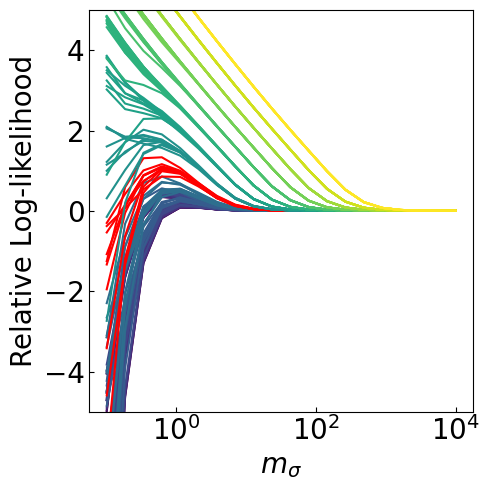

In [26]:
n_trial = 10
filter_size = 0.27
I_bg = 0.01
use_log_I = False
use_log_Q = False
# Transformations on Q and I(Q)
f_Q = lambda q: q
f_inv_Q = lambda fq: fq
if use_log_Q:
    f_Q = lambda q: np.log(q)
    f_inv_Q = lambda fq: np.exp(fq)


f_I = lambda I: I
f_inv_I = lambda fI: fI
# if use_log_I:
#     f_I = lambda I: np.log(I+I_bg)
#     f_inv_I = lambda fI: np.exp(fI)-I_bg
if use_log_I:
    f_I = lambda I: f_loglin(I, x_c=I_bg*2)
    f_inv_I = lambda fI: f_loglin_inv(fI, y_c=np.log(I_bg*2))

def get_viridis_color(value):
    cmap = plt.get_cmap('viridis')
    return cmap(value)

fig = plt.figure(figsize=(5, 5))

# n_sample_list = np.array([1000, 2000, 5000, 10000, 20000, 50000, 100000])
# n_sample_list = np.linspace(1000, 20000, 10)
n_sample_list = np.logspace(1, 8, 15)

list_L_gpr = []
list_L_exp = []
list_mse_gpr = []
list_mse_exp = []
list_G_acc_gpr = []
list_G_acc_exp = []
list_G_m = []
for i_n, n_sample in enumerate(n_sample_list):
    
    ax = plt.subplot(1, 1, 1)

    n_sample = int(n_sample)
    color = get_viridis_color(i_n/(len(n_sample_list)-1))
    
    dq = q_grid[1] - q_grid[0]

    log_likelihood_gt_exp = 0
    log_likelihood_gt_gpr = 0
    mse_exp = 0
    mse_gpr = 0
    G_acc_gpr = 0
    G_acc_exp = 0
    G_m = 0
    
    for i_trial in range(n_trial):
        np.random.seed(114514)
        seed_trial = np.random.randint(1e6)+i_trial*23
        np.random.seed(None)
        I_q_grid = f_I_q(n_sample, p_ts, seed=seed_trial) ## count per pixel
        I_q, sum_q, n_pixels_q, I_pixels_q = f_I_q_rad(I_q_grid, q)
        I_q_th, _, _, _ = f_I_q_rad(p_ts, q)
        I_q_th = I_q_th*n_sample
        
        #override I_q by given y_err
        y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))
        np.random.seed(seed_trial)
        I_q = (I_q_th + np.random.normal(size = I_q.shape)*y_err_pixel)
        np.random.seed(None)
        
        I_q_gf = np.zeros_like(q)
        for i_iterate in range(1):
            I_q_gf_i = np.zeros_like(q)
            I_iterate = I_q - I_q_gf
            for i in range(len(q)):
                weight_list = np.exp(-((f_Q(q[i])-f_Q(q))/filter_size)**2/2)
                weight_list = weight_list/np.sum(weight_list)
                I_q_gf_i[i] = np.sum(I_iterate*weight_list)
            # n_sm = 2
            # I_q_gf_i[n_sm:-n_sm] = desmear(f_Q(q), I_q_gf_i, I_q_gf_i*0+1, np.ones_like(I_q_gf)*filter_size, n=n_sm, sigmascale=1)
            I_q_gf = I_q_gf + I_q_gf_i
            
        # I_q_gf = gaussian_filter1d(I_q, filter_size, mode='nearest')
        
        I_err_q = np.sqrt(1/n_pixels_q*[np.sum(I) for I in I_pixels_q]) # var: 1/n_pixels*sum(I)

        ## GPR
        sigma_list = np.logspace(-1, 4, 20)
        log_likelihood_list = []
        for sigma in sigma_list:
            lmbda = filter_size
            # lmbda = 0.36
            # sigma = 10

            ## define kernel function
            y_data = f_I(I_q/n_sample*n_grid)
            y_gt = f_I(I_q_th/n_sample*n_grid)
            y_bg = f_I(I_q_gf/n_sample*n_grid)
            # y_bg = y_gt
            y = y_data-y_bg

            # y_err = np.sqrt(n_sample/np.sum(n_pixels_q)*1/np.maximum(sum_q,np.ones_like(q)))
            y_err_pixel = np.sqrt(n_sample/np.sum(n_pixels_q)*(1/np.maximum(n_pixels_q,np.ones_like(q))))/n_sample*n_grid
            y_err = y_err_pixel
            if use_log_I:
                y_err = y_err_pixel*f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)

            # scale by a factor to check whether error estimation is correct
            m_factor = 1
            y_bg = y_bg*m_factor
            y_gt = y_gt*m_factor
            y = y*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))*np.random.normal(size = y.shape)
            y_err = y_err*m_factor #+ 1e-5*(np.max(y_gt)-np.min(y_gt))
            y_data = y_data*m_factor
            sig_var = np.mean(y**2)
            
            # fluctuations of the prior distribution
            prior_sigma = np.sqrt(sig_var)
            # prior_sigma = np.sqrt(np.mean(y_err**2))
            # prior_sigma = np.sqrt(y_err**2+sig_var) 

            q_x = q
            q_s = q

            def f_K_rbf(q1, q2, lmbda, std_1=None, std_2=None):
                if std_1 is None:
                    std_1 = np.ones_like(q1)
                if std_2 is None:
                    std_2 = np.ones_like(q2)
                K = np.exp(-(q1[:, None] - q2[None, :])**2 / lmbda**2/2)*std_1[:, None]*std_2[None, :]
                return K
            
            f_y_err = lambda y_err: sigma**2*(y_err**2/np.sqrt(sig_var)**2)
            K_sigma = np.diag(f_y_err(y_err))
            # K_sigma = sigma**2*np.eye(len(q_x))
            K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma #+ 0*np.eye(len(q_x))
            K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
            k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

            L = np.linalg.cholesky(K_xx)
            alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
            v = np.linalg.solve(L, K_xs)
            mu_s = K_xs.T @ alpha
            cov_s = k_ss - v.T @ v
            var_s = np.diag(cov_s)*prior_sigma**2
            std_s = np.sqrt(var_s)

            # evaluate the log likelihood
            log_likelihood = f_log_likelihood(y, y_err, mu_s, std_s)  
            log_likelihood_list.append(log_likelihood)
            
        log_likelihood_list = np.array(log_likelihood_list)
        log_likelihood_list = (log_likelihood_list - log_likelihood_list[-1])/len(q_s)

        if n_sample == 10000:
            color = 'r'
        ax.plot(sigma_list, log_likelihood_list, '-', color=color, label=f'${n_sample:.0e}$'.replace('e+0', r'\times 10^'))
        ax.set_xscale('log')
        ax.set_ylim([-5, 5])
        ax.tick_params(direction='in', labelsize=20)
        ax.set_xlabel(r'$m_\sigma$', fontsize=20)
        ax.set_ylabel(r'Relative Log-likelihood', fontsize=20)

        sigma_best = sigma_list[np.argmax(log_likelihood_list)]
        sigma_best = 1
        
        # ax.legend(frameon=False, fontsize=13, ncol=2)
        plt.tight_layout()

        # GPR with best sigma
        f_y_err = lambda y_err: sigma_best**2*(y_err**2/np.sqrt(sig_var)**2)
        K_sigma = np.diag(f_y_err(y_err))
        # K_sigma = sigma**2*np.eye(len(q_x))
        K_xx = f_K_rbf(f_Q(q_x), f_Q(q_x), lmbda) + K_sigma
        K_xs = f_K_rbf(f_Q(q_x), f_Q(q_s), lmbda)
        k_ss = f_K_rbf(f_Q(q_s), f_Q(q_s), lmbda)

        L = np.linalg.cholesky(K_xx)
        alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
        v = np.linalg.solve(L, K_xs)
        mu_s = K_xs.T @ alpha
        cov_s = k_ss - v.T @ v
        var_s = np.diag(cov_s)*prior_sigma**2
        std_s = np.sqrt(var_s)
        
        I_mean_GP = f_inv_I(mu_s + y_bg)
        I_std_GP = std_s
        if use_log_I:
            I_std_GP = std_s/f_loglin_deriv(I_q/n_sample*n_grid, x_c=I_bg)
            
        delta_gp_bg = np.sqrt((f_inv_I(y_gt)-f_inv_I(y_bg))**2)
        # sigma_gt = np.ones_like(y_gt)*(np.max(y_gt)-np.min(y_gt))*1e-3
        sigma_gt = prior_sigma
        
        # Calculate the in terms of cross entropy      
        # h_gt_m = -f_log_likelihood((y_gt), sigma_gt, (y_bg), prior_sigma, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_gpr = -f_log_likelihood((y_gt), sigma_gt, (mu_s + y_bg), std_s, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        # h_gt_exp = -f_log_likelihood((y_gt), sigma_gt, (y_data), y_err, z_list=np.linspace(-4, 4, 49))/len(q)#, z_list=np.linspace(-4, 4, 49))/len(q)#
        
        h_m_gt = f_log_likelihood((y_bg), prior_sigma, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_gpr_gt = f_log_likelihood((mu_s + y_bg), std_s, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        h_exp_gt = f_log_likelihood((y_data), y_err, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)
        
        G_acc_gpr += h_gpr_gt#-h_m_gt
        G_acc_exp += h_exp_gt#-h_m_gt
        G_m += h_m_gt
        
    list_G_acc_gpr.append(G_acc_gpr/n_trial)
    list_G_acc_exp.append(G_acc_exp/n_trial)
    list_G_m.append(G_m/n_trial)

# convert the lists to numpy arrays
list_G_acc_gpr = np.array(list_G_acc_gpr)
list_G_acc_exp = np.array(list_G_acc_exp)
list_G_m = np.array(list_G_m)

/tmp/ipykernel_2866211/833206668.py:53: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "or" (-> color='r'). The keyword argument will take precedence.
  ax.plot(n_sample_list, time_gpr, 'or', color='k')
/tmp/ipykernel_2866211/833206668.py:54: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Slope: -0.5826555967360533


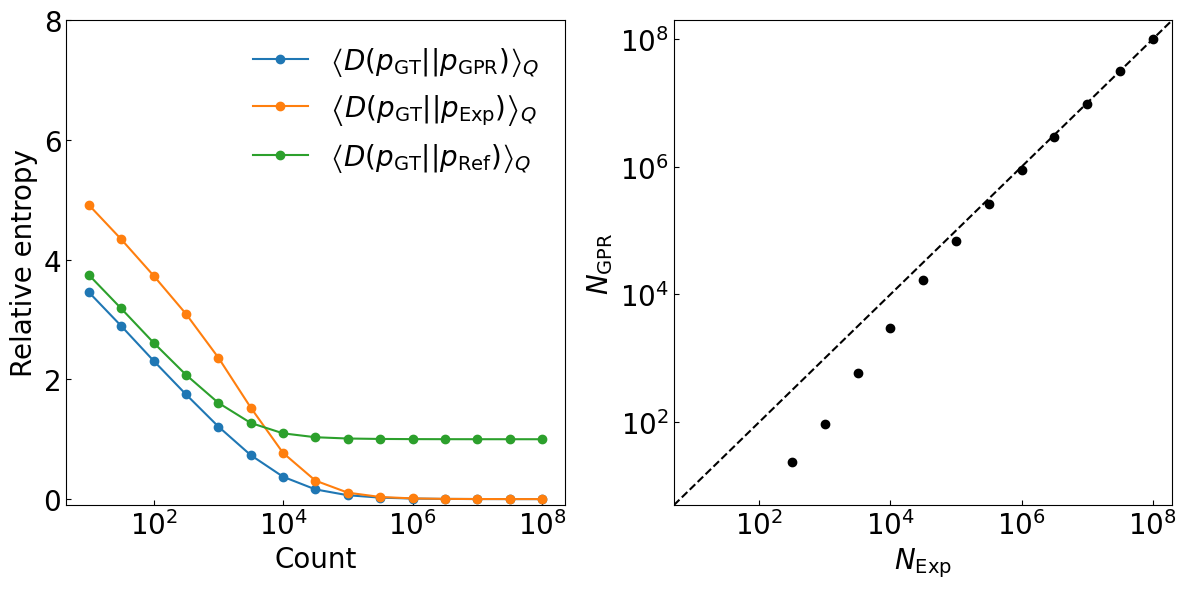

In [27]:
h_gt_gt = f_log_likelihood((y_gt), sigma_gt, (y_gt), sigma_gt, z_list=np.linspace(-4, 4, 49))/len(q)

# Filter the data for n_sample_list < 10000
mask = n_sample_list < 10000
x_fit = np.log(n_sample_list[mask])
y_fit = list_G_acc_exp[-1] - list_G_acc_exp[mask]

# Calculate the slope
slope, intercept = np.polyfit(x_fit, y_fit, 1)
print(f"Slope: {slope}")

# Create duplicates for quantities to be plotted to prevent overwrite
list_G_acc_gpr_dup = list_G_acc_gpr.copy()
list_G_acc_exp_dup = list_G_acc_exp.copy()
list_G_m_dup = list_G_m.copy()
# Create a figure with 3 subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the gain as a function of time
ax = axs[0]
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_gpr, '-o', color='C0', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{GPR}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_acc_exp, '-o', color='C1', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Exp}})\right\rangle_{Q}$')
ax.plot(n_sample_list, list_G_acc_exp[-1]-list_G_m, '-o', color='C2', label=r'$\left\langle D(p_{\mathrm{GT}}||p_{\mathrm{Ref}})\right\rangle_{Q}$')
ax.legend(frameon=False, fontsize=20)
ax.set_xticks(n_sample_list)
ax.set_xscale('log')
ax.set_ylim([-0.1, 8])
ax.tick_params(direction='in', labelsize=20)
ax.set_xlabel(r'Count', fontsize=20)
ax.set_ylabel(r'Relative entropy', fontsize=20)

# # Plot the gain as a function of time
# ax = axs[1]
# ax.plot(n_sample_list, list_G_m-list_G_acc_gpr, '-o', color='C0', label=r'$\Delta H_\mathrm{GPR}$')
# ax.plot(n_sample_list, list_G_m-list_G_acc_exp, '-o', color='C1', label=r'$\Delta H_\mathrm{Exp}$')
# ax.plot(n_sample_list, np.ones_like(n_sample_list)*-0.28, '--k')
# ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
# ax.set_xscale('log')
# ax.set_ylim([-1, 2])
# ax.tick_params(direction='in', labelsize=20)
# ax.set_xlabel(r'Count', fontsize=20)
# ax.set_ylabel(r'Relative entropy', fontsize=20)

ax = axs[1]
f_interp_gpr = interp1d(list_G_acc_gpr[-1]-list_G_acc_gpr, n_sample_list, kind='linear', fill_value='extrapolate')

time_gpr = np.zeros_like(n_sample_list)
for i in range(len(list_G_acc_exp)):
    H_exp_gt_i = list_G_acc_exp[-1]-list_G_acc_exp[i]
    time_gpr[i] = f_interp_gpr(H_exp_gt_i)

ax.plot(n_sample_list, time_gpr, 'or', color='k')
ax.plot([1e1/2, 1e8*2], [1e1/2, 1e8*2], '--k', color='k')
ax.legend(frameon=False, fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([1e1/2, 1e8*2])
ax.set_ylim([1e1/2, 1e8*2])
ax.legend(frameon=False, fontsize=20)
# ax.set_xticks(n_sample_list)
ax.tick_params(direction='in', labelsize=20)
# ax.tick_params(axis='x', direction='in', labelsize=18)
ax.set_xlabel(r'$N_\mathrm{Exp}$', fontsize=20)
ax.set_ylabel(r'$N_\mathrm{GPR}$', fontsize=20)

plt.tight_layout()

filename = 'dKL_synth_ts.dat'
np.savetxt(filename, np.c_[n_sample_list, list_G_acc_gpr, list_G_acc_exp, list_G_m], header='time/counts D_GPR D_Exp D_Ref')
